## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [154]:
# Your code here - remember to use markdown cells for comments as well!

Imported the appropriate libraries to be used for this data exploration and analysis

In [155]:
import pandas as pd
import gzip as gz
import matplotlib.pyplot as plt
import sqlite3
import os
import zipfile
import seaborn as sns
import math
import numpy as np

Opened the relevant databases to be explored in Jupyter notebook

In [156]:
# Opened the relevant datasets to be explored in jupyter notebook
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip,path='zippedData/')
with gz.open('zippedData/rt.reviews.tsv.gz') as f:
    rt_reviews = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/rt.movie_info.tsv.gz') as f:
    rt_movie_info = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/tmdb.movies.csv.gz') as f:
    tmdb_movies = pd.read_csv(f)
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)
with gz.open('zippedData/bom.movie_gross.csv.gz') as f:
    bom_movie_gross = pd.read_csv(f)

Connected to im_db to utilize data and created a SQL query to pull information from the tables in the database

In [157]:
im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)
im_db_ratings = pd.read_sql("""SELECT * FROM movie_ratings""",im_db)
im_db_persons = pd.read_sql("""SELECT * FROM persons""",im_db)
im_db_principals = pd.read_sql("""SELECT * FROM principals""",im_db)

In [158]:
# Created a SQL query to pull director name and info from the imdb database
director_info = """
SELECT
    m.movie_id,
    m.primary_title,
    m.genres,
    d.person_id,
    p.primary_name,
    p.death_year
    
    
FROM
    movie_basics AS m
    JOIN 
        directors AS d ON m.movie_id = d.movie_id
    JOIN
        known_for AS kf ON m.movie_id = kf.movie_id
    JOIN
        persons AS p ON p.person_id = d.person_id
GROUP BY
    m.movie_id, kf.person_id, p.primary_name
;
"""
director_info_result = pd.read_sql(director_info, im_db)
director_info_result

,movie_id,primary_title,genres,person_id,primary_name,death_year
0,tt0063540,Sunghursh,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,2004.0
1,tt0063540,Sunghursh,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,2004.0
2,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
3,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
4,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
...,...,...,...,...,...,...
991711,tt9916754,Chico Albuquerque - Revelações,Documentary,nm8349149,Vinicius Augusto Bozzo,NaN
991712,tt9916754,Chico Albuquerque - Revelações,Documentary,nm9272490,Angela Gurgel,NaN
991713,tt9916754,Chico Albuquerque - Revelações,Documentary,nm8349149,Vinicius Augusto Bozzo,NaN
991714,tt9916754,Chico Albuquerque - Revelações,Documentary,nm9272490,Angela Gurgel,NaN


In [159]:
director_info_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991716 entries, 0 to 991715
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       991716 non-null  object 
 1   primary_title  991716 non-null  object 
 2   genres         973303 non-null  object 
 3   person_id      991716 non-null  object 
 4   primary_name   991716 non-null  object 
 5   death_year     5020 non-null    float64
dtypes: float64(1), object(5)
memory usage: 45.4+ MB


Initially we wanted to pull the information from the director's tables to find a correlation between movie revenue and directors, but once we merged all the data together there was a lot of missing data for the domestic directors.

In [160]:
# Created a new variable that filtered the director_info_results to drop all director's who are deceased
# and to drop any duplicate movie_ids 
clean_director_info = director_info_result[director_info_result['death_year'].isnull()].drop_duplicates(['primary_title'])
clean_director_info[clean_director_info['primary_name'] == 'James Cameron']

,movie_id,primary_title,genres,person_id,primary_name,death_year
76842,tt1630029,Avatar 2,"Action,Adventure,Fantasy",nm0000116,James Cameron,NaN
115933,tt1757678,Avatar 3,"Action,Adventure,Drama",nm0000116,James Cameron,NaN
401367,tt3095356,Avatar 4,"Action,Adventure,Fantasy",nm0000116,James Cameron,NaN


First, look at the data from tn_movie_budgets.csv. This data contains a release date and budget as well as domestic and worldwide revenue for each movie. The financials are in string form with punctuation, but we should make them integers so we can perform math operations later. We can also determine the foreign revenue from the domestic and worldwide numbers. Finally, we only keep the relevant columns so we can merge the data with other sets later.

In [161]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype('int64')
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)
#tn_movie_budgets.info()
tn_relevant_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn_relevant = tn_movie_budgets[tn_relevant_cols]
#tn_relevant.head()

Next, we look at the data from bom_movie_gross.csv. This data is similar to the tn_movie_budgets but has foreign revenue instead of worldwide, and does not contain budget data. We should make all of the financials integers and calculate the foreign revenue from domestic and worldwide so it is easier to join with the other sets. Once again we only keep relevant columns.

In [162]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].fillna('0')
bom_movie_gross.dropna(inplace=True)
bom_movie_gross['clean_domestic'] = bom_movie_gross['domestic_gross'].astype(int)
bom_movie_gross['clean_foreign'] = bom_movie_gross['foreign_gross'].str.replace(',','').astype(float)
bom_movie_gross['clean_foreign'] = bom_movie_gross['clean_foreign'].apply(math.trunc)
bom_movie_gross['clean_worldwide'] = bom_movie_gross['clean_domestic'] + bom_movie_gross['clean_foreign']
#bom_movie_gross.info()
bom_relevant_cols = ['title','year','clean_domestic','clean_foreign','clean_worldwide', 'studio']
bom_relevant = bom_movie_gross[bom_relevant_cols]
#bom_relevant.head()

Here we combine the two financial data sets from before keeping only one entry for the movies present in both datasets. We decided to assume the median budget for the movies that did not have budget information in the datasets. This seems ok because only about 1/4 of the data does not have budget information. We then calculated total profit and return on investment for each movie in the dataset.

In [251]:
combined_financials = pd.concat([tn_relevant,bom_relevant],ignore_index=True)
combined_financials = combined_financials.drop_duplicates(subset='title',keep='first')
#combined_financials.plot('clean_domestic','clean_foreign',kind='scatter')

#Much of the budget column is empty because bom_movie_gross does not include budget information
#Going to fill the NA budgets with the median value
combined_financials['clean_budget'].fillna(combined_financials['clean_budget'].median(),inplace=True)
combined_financials['roi_domestic'] = 100 * (combined_financials['clean_domestic'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['roi_worldwide'] = 100 * (combined_financials['clean_worldwide'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['clean_profit'] = combined_financials['clean_worldwide'] - combined_financials['clean_budget']
combined_financials.head()
combined_financials.describe()

,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
count,7.818000e+03,7.818000e+03,7.818000e+03,7.818000e+03,7818.000000,7818.000000,7.818000e+03
mean,2.779707e+07,3.327278e+07,4.192367e+07,7.519645e+07,122.636367,282.300451,4.739938e+07
std,3.643610e+07,6.429192e+07,1.056781e+08,1.629756e+08,2224.875807,2517.190075,1.395834e+08
min,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-100.000000,-100.000000,-2.002376e+08
25%,9.000000e+06,2.033505e+05,0.000000e+00,7.147500e+05,-97.935294,-91.896985,-1.300000e+07
50%,1.700000e+07,6.860551e+06,2.068436e+06,1.461086e+07,-49.910638,8.696117,4.679410e+05
75%,3.000000e+07,3.916726e+07,3.309207e+07,7.191611e+07,64.050156,215.144340,4.160456e+07
max,4.250000e+08,9.367000e+08,2.015838e+09,2.776345e+09,179900.000000,179900.000000,2.351345e+09


We now take the data from im_db (which has no financial information) and merge it with the financial data. We then remove the movies from the dataframe with no financial information because having financial information is necessary for us to make any use of the movie data. This leaves us with around 3,500 movies.

In [164]:
all_movie_data = clean_director_info.merge(combined_financials, left_on = 'primary_title',right_on ='title', how = 'inner')
all_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3667 entries, 0 to 3666
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3667 non-null   object 
 1   primary_title    3667 non-null   object 
 2   genres           3656 non-null   object 
 3   person_id        3667 non-null   object 
 4   primary_name     3667 non-null   object 
 5   death_year       0 non-null      float64
 6   title            3667 non-null   object 
 7   year             3667 non-null   object 
 8   month            2260 non-null   object 
 9   clean_budget     3667 non-null   float64
 10  clean_domestic   3667 non-null   int32  
 11  clean_foreign    3667 non-null   int64  
 12  clean_worldwide  3667 non-null   int64  
 13  studio           1407 non-null   object 
 14  roi_domestic     3667 non-null   float64
 15  roi_worldwide    3667 non-null   float64
 16  clean_profit     3667 non-null   float64
dtypes: float64(5),

In [165]:
im_db_combined = im_db_basics.merge(im_db_ratings,on='movie_id',how='inner')
im_db_combined = im_db_combined.drop_duplicates(subset = 'primary_title', keep='first')
im_db_combined.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_with_financial = im_db_combined.merge(combined_financials,on = 'title',how = 'inner')

In [166]:
genre_set = set()
genre_df = im_db_with_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
genre_list = list(genre_set)

In [217]:
genre_plot_roi = []
genre_plot_profit = []
genre_profit_dict = {'genres':[], 'profit':[]}
for genre in genre_set:
    roi_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['roi_worldwide']
    roi_series.rename(genre,inplace=True)
    genre_plot_roi.append(roi_series)
    profit_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['clean_profit']
    worldwide_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['clean_worldwide']
    profit_series.rename(genre,inplace=True)
    genre_profit_dict['genres'].append(genre)
    genre_profit_dict['profit'].append(worldwide_series.median())
    genre_plot_profit.append(profit_series)
    #print(genre, profit_series.median()

In [218]:

profit_df = pd.DataFrame(genre_profit_dict)
print(profit_df)
print(genre)

         genres       profit
0      Thriller   10665890.5
1       History    3836339.5
2        Horror    8951047.0
3         Music    3575000.0
4       Romance    3728400.0
5       Western    2134964.0
6   Documentary     661221.0
7        Sci-Fi   66540205.0
8           War    1757000.0
9          News   23371889.0
10        Crime    8002293.5
11       Family   35609577.0
12      Mystery   10523789.5
13        Sport    6590000.0
14       Comedy   11456602.0
15    Biography    6938597.5
16    Animation  108119662.0
17       Action   48559676.5
18    Adventure  134772743.5
19      Fantasy   47007265.0
20      Musical     849665.0
21        Drama    3755000.0
Drama


In [ ]:
Created a boxplot of the return on investment(ROI) for genres versus profit. ROI was calculated as:

 100 *(worldwide gross - budget) / budget

We used worldwide gross because we believed that it would be a more accurate representation of the profit margins of the movie. The top 5 studios are US based studios, however their movies have international reach
and we believe that it is better to get the bigger picture when it comes to profits. 


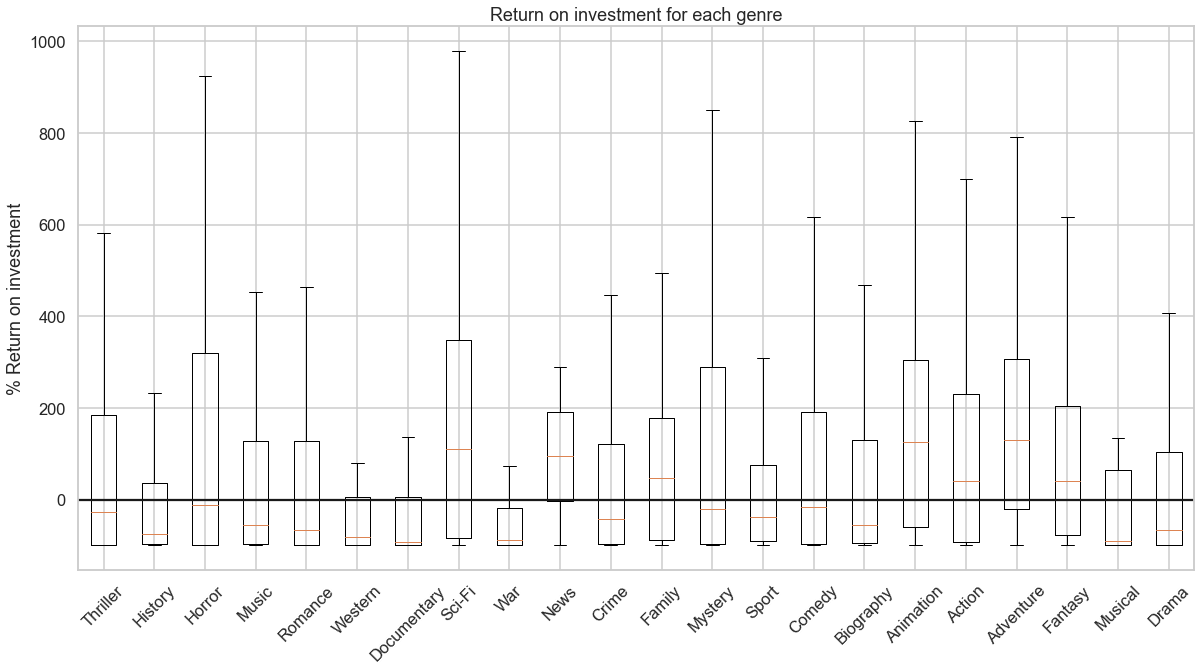

In [219]:
fig,ax = plt.subplots(figsize = (20,10))
ax.boxplot(genre_plot_roi,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax.tick_params(axis='x',labelrotation=45)
ax.axhline(y=0, color='k');
ax.set_title('Return on investment for each genre');
ax.set_ylabel('% Return on investment');

In [248]:
#genre_means = movies_df_from_top30.groupby(genre_set).mean().sort_values('clean_worldwide',ascending=False)
#genre_median = movies_df_from_top30.groupby('genres').median().sort_values('clean_worldwide',ascending=False)
#genre_median.head()
positive_profit = profit_df[profit_df['profit'] > 0].sort_values('profit', ascending = False)
positive_profit_names = positive_profit['genres'].tolist()


We then selected the top six genres and plotted them along the x-axis. We then plotted median gross measured in millions of USD on the y-axis of the barchart below. 
We chose to plot the median of the dataset instead of the mean because the dataset had some outliers that would not accurately represent the mean data.
This graph is a simpler representation of the box plot graph above.

<ipython-input-249-cae1d3654305>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


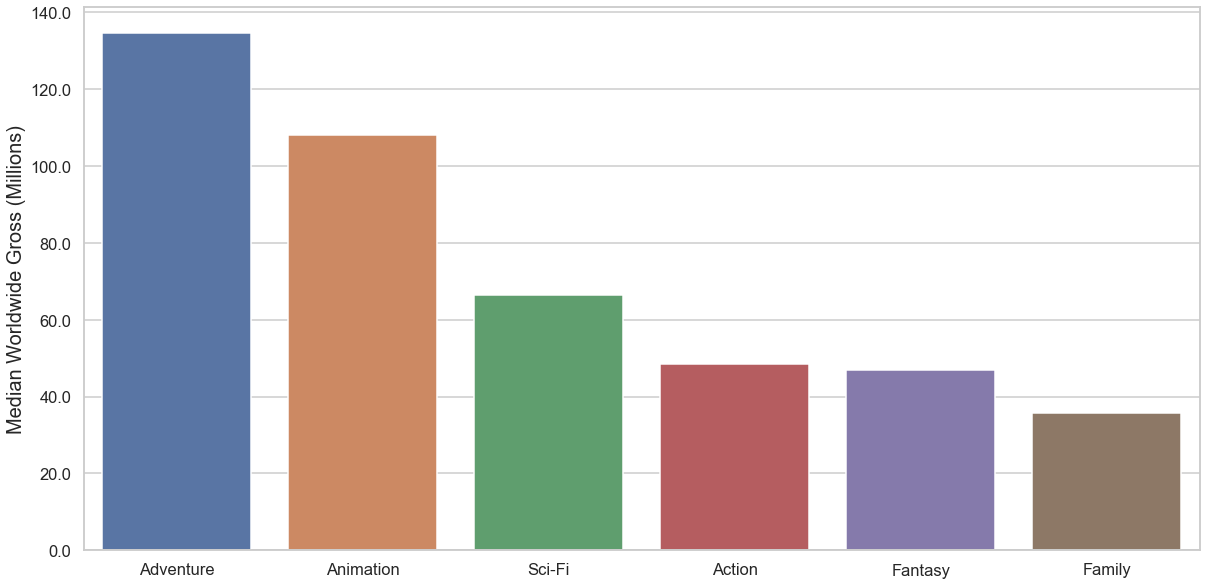

In [249]:
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = positive_profit_names[:6], y = positive_profit['profit'][:6])
sns.set_theme(context = 'talk',style='whitegrid')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
# ax.set_title('Top 5 Movie Studios', fontsize = 32)
ax.set_ylabel('Median Worldwide Gross (Millions)', fontsize = 20)
ax.set_yticklabels(ax.get_yticks()//1000000);

The graph below shows the profit per genre in hundreds of millions USD

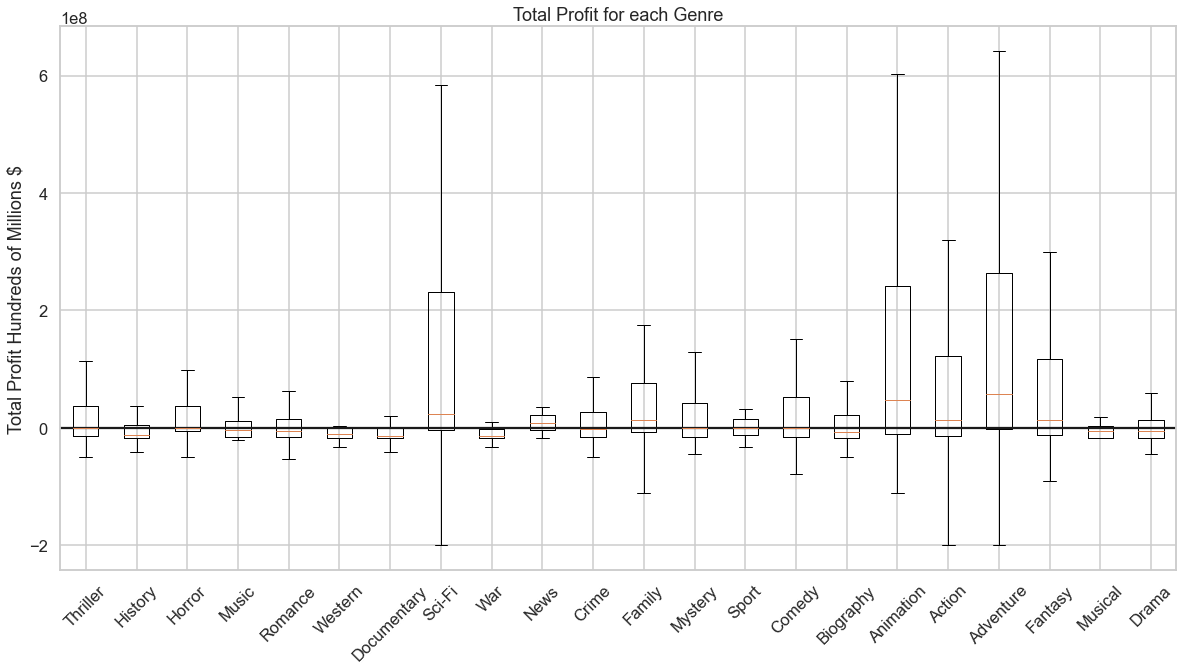

In [ ]:
fig2,ax2 = plt.subplots(figsize = (20,10))
ax2.boxplot(genre_plot_profit,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax2.tick_params(axis='x',labelrotation=45)
ax2.axhline(y=0, color='k');
ax2.set_title('Total Profit for each Genre');
ax2.set_ylabel('Total Profit Hundreds of Millions $');

Created new dataframes so that the original merged data set would still be intact.

In [ ]:
studio_and_budget_df = all_movie_data
director_and_budget_df = all_movie_data

Dropped any of the rows in the data frame where the studio column had any value that was NaN. 
Dropped any of the rows in the director and budget data frame where the primary_name column had any NaN values

In [ ]:
studio_and_budget_df[studio_and_budget_df['studio'].isna()]
studio_and_budget_df.dropna(subset=['studio'], inplace = True)
director_and_budget_df.dropna(subset=['primary_name'], inplace = True)

Checked to see the amount of movies each studio made.

In [ ]:
studio_and_budget_df['studio'].value_counts()[:30]

IFC        100
Magn.       86
SPC         66
Eros        66
Strand      49
KL          45
WGUSA       43
CJ          41
CL          39
UTV         36
MBox        35
Cohen       32
FM          31
RAtt.       31
Wein.       26
LGF         24
A24         21
FIP         18
Osci.       17
FoxS        16
GK          16
BV          16
Drft.       16
Gold.       15
Focus       14
Relbig.     12
Uni.        12
Zeit.       12
Sony        12
EOne        12
Name: studio, dtype: int64

Created a list of the top_30_studio_names and created a new data frame where only the movies associated with the top 30 studios would be present.

In [ ]:
top_30_studio_names = list(studio_and_budget_df['studio'].value_counts()[:30].index)
# print(top_30_studio_names)
movies_df_from_top30 = studio_and_budget_df[studio_and_budget_df['studio'].isin(top_30_studio_names)]
# movies_df_from_top30.head()

Created a studio_means and studio_median variable and assigned them their approrpiate statistical value.

In [ ]:
studio_means = movies_df_from_top30.groupby('studio').mean().sort_values('clean_worldwide',ascending=False)
studio_median = movies_df_from_top30.groupby('studio').median().sort_values('clean_worldwide',ascending=False)

In [ ]:
studio_means.head()

,death_year,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
studio,,,,,,,,
BV,NaN,17000000.0,1.042812e+08,1.489632e+08,2.532444e+08,513.419117,1389.673161,2.362444e+08
Uni.,NaN,17000000.0,6.435183e+07,1.369333e+08,2.012852e+08,278.540196,1084.030392,1.842852e+08
WGUSA,NaN,17000000.0,4.470163e+05,5.302435e+07,5.347137e+07,-97.370492,214.537442,3.647137e+07
LGF,NaN,17000000.0,1.362822e+07,2.790262e+07,4.153085e+07,-19.833971,144.299118,2.453085e+07
Sony,NaN,17000000.0,3.004333e+06,3.572500e+07,3.872933e+07,-82.327451,127.819608,2.172933e+07


Created a function called season_category that filtered the months into specific season categories.

In [ ]:
def season_category(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return  'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    else:
        return 'Autumn'

In [ ]:
tn_relevant['Seasons'] = tn_relevant['month'].apply(season_category)

<ipython-input-81-234ffe314853>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_relevant['Seasons'] = tn_relevant['month'].apply(season_category)


Imported necessary libraries to visualize different colors to use for the graphs that we generated using Seaborne.

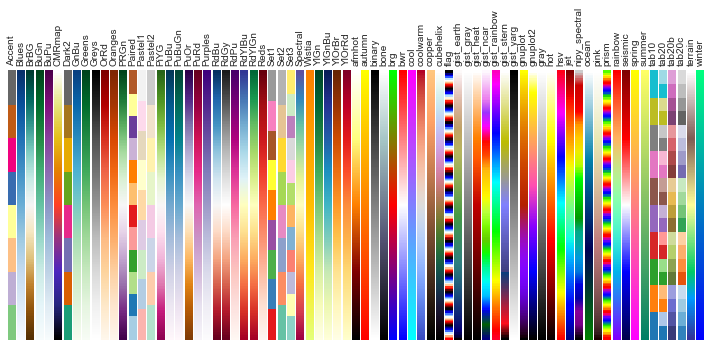

In [ ]:
from pylab import *
from numpy import outer
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(10,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cm.datad if not m.endswith("_r")]
maps.sort()
l=len(maps)+1
for i, m in enumerate(maps):
     subplot(1,l,i+1)
     axis("off")
     imshow(a,aspect='auto',cmap=get_cmap(m),origin="lower")
     title(m,rotation=90,fontsize=10)
savefig("colormaps.png",dpi=100,facecolor='gray')

<ipython-input-87-72cab3167cb2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(ax4.get_yticks()//1000000);


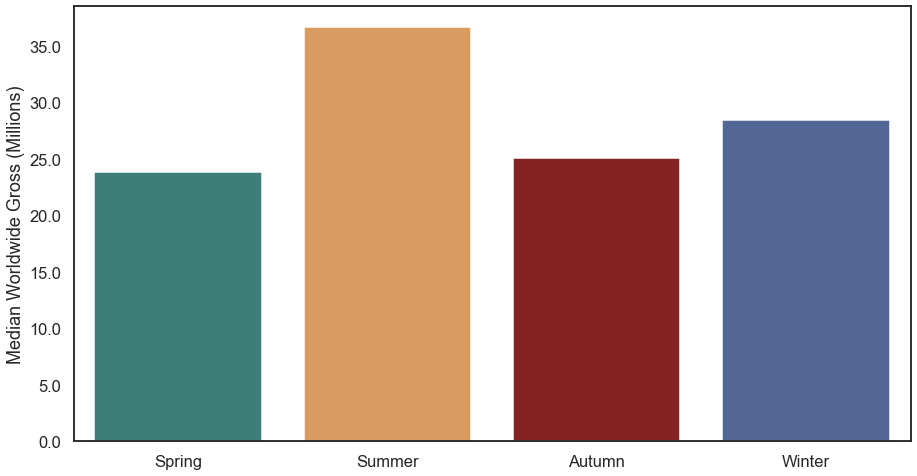

In [ ]:
colors = ["#348781","#EE9A4D","#931314","#4863A0" ]
sns.set_palette(sns.color_palette(colors))
seasons_in_order = ['Spring','Summer','Autumn','Winter']
tn_plot_season = tn_relevant.groupby('Seasons').agg(median_earning=('clean_worldwide','median'))
tn_plot_season= tn_plot_season.reset_index()
sns.set(rc = {'figure.figsize':(15,8)});
sns.set_theme(context = 'talk',style='white');
sns.set_palette(sns.color_palette(colors));
ax4 = sns.barplot(x='Seasons',y='median_earning',data=tn_plot_season,order=seasons_in_order)
ax4.set_ylabel('Median Worldwide Gross (Millions)');
ax4.set_xlabel(None);
# ax4.set_title('',fontsize=32);
ax4.set_yticklabels(ax4.get_yticks()//1000000);

<ipython-input-86-dc9ff4c83e43>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(ax4.get_yticks()//1000000);


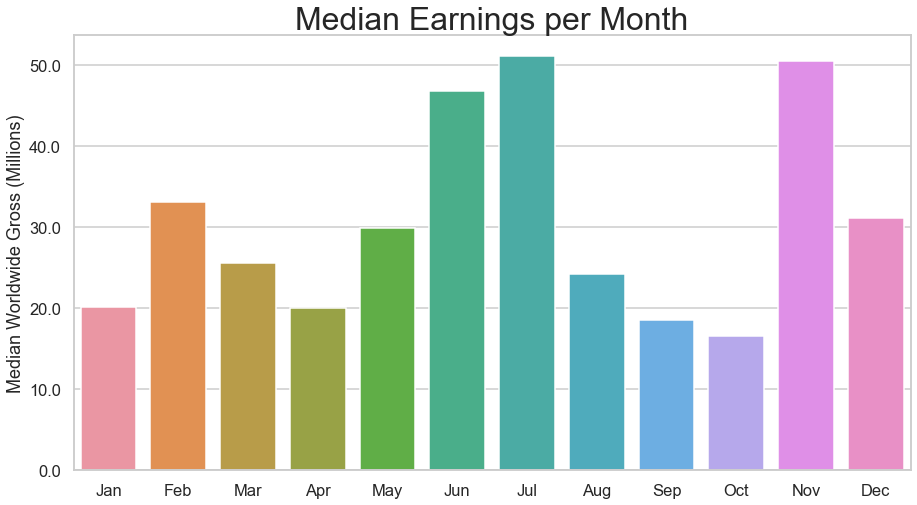

In [ ]:
months_in_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tn_plot_month = tn_relevant.groupby('month').agg(median_earning=('clean_worldwide','median'))
tn_plot_month= tn_plot_month.reset_index()
sns.set(rc = {'figure.figsize':(15,8)});
sns.set_theme(context = 'talk',style='whitegrid');
ax4 = sns.barplot(x='month',y='median_earning',data=tn_plot_month,order=months_in_order)
ax4.set_ylabel('Median Worldwide Gross (Millions)');
ax4.set_xlabel(None);
ax4.set_title('Median Earnings per Month',fontsize=32);
ax4.set_yticklabels(ax4.get_yticks()//1000000);

In [ ]:
print(type(studio_median['clean_worldwide']))

<class 'pandas.core.series.Series'>


<ipython-input-95-8c7dc731d497>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


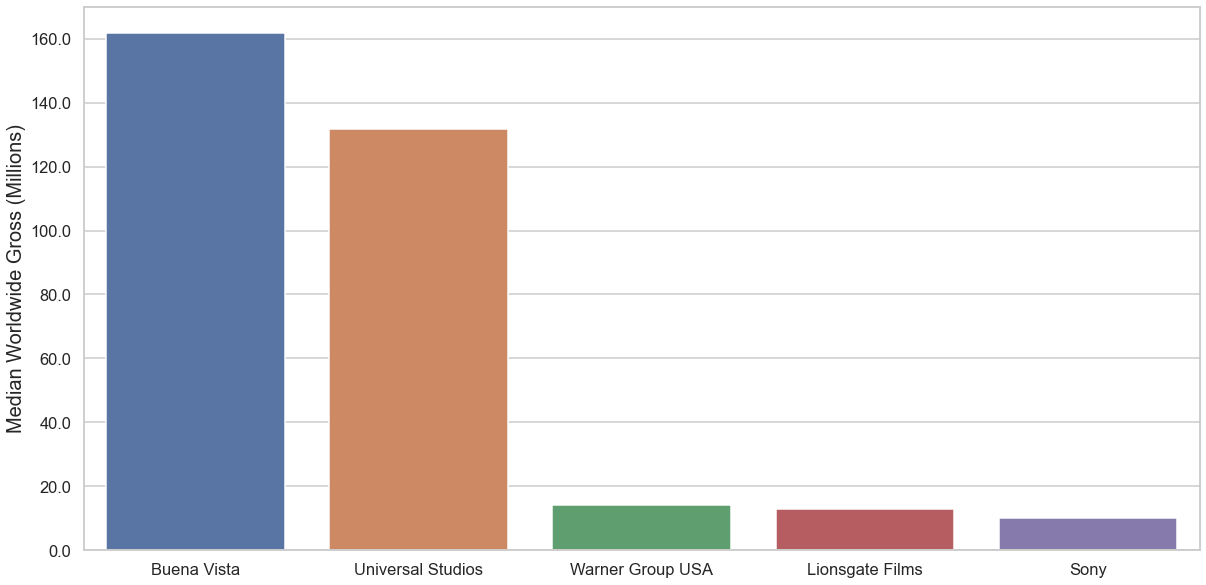

In [ ]:
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = ['Buena Vista', 'Universal Studios', 'Warner Group USA', 'Lionsgate Films', 'Sony'], y =studio_median['clean_worldwide'][:5])
sns.set_theme(context = 'talk',style='whitegrid')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
# ax.set_title('Top 5 Movie Studios', fontsize = 32)
ax.set_ylabel('Median Worldwide Gross (Millions)', fontsize = 20)
ax.set_yticklabels(ax.get_yticks()//1000000);

<ipython-input-96-2be1070f64e7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks()//1000000);


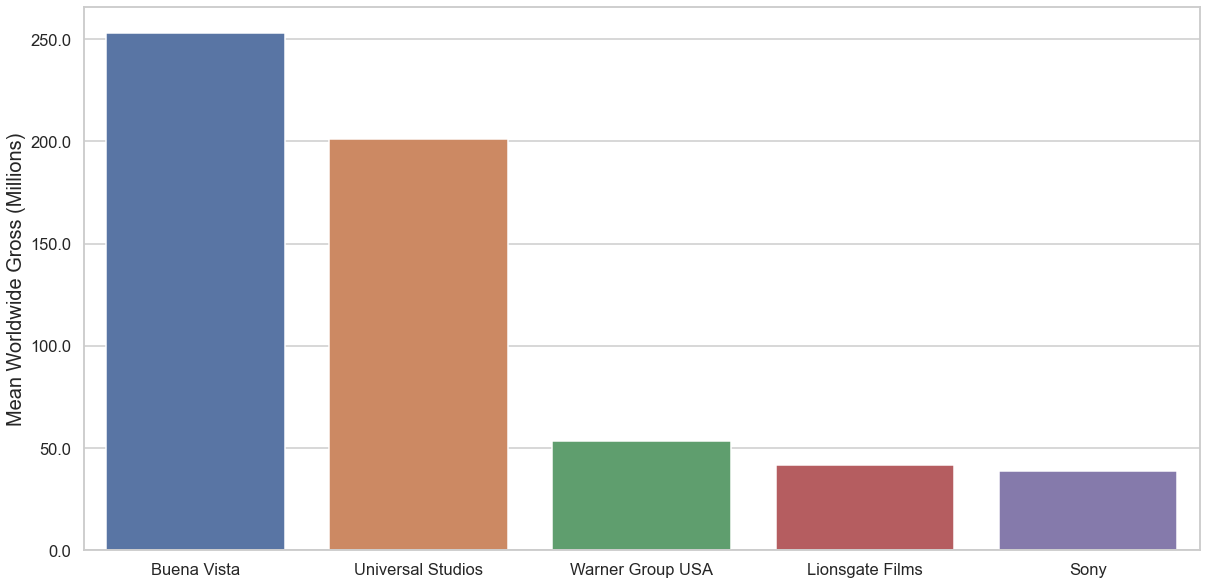

In [ ]:
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = ['Buena Vista', 'Universal Studios', 'Warner Group USA', 'Lionsgate Films', 'Sony'], y =studio_means['clean_worldwide'][:5])
sns.set_theme(context = 'talk',style='whitegrid')
fig.patch.set_facecolor('xkcd:white')
# ax.set_xlabel('Movie Studios')
# ax.set_title('Top 5 Movie Studios', fontsize = 32)
ax.set_ylabel('Mean Worldwide Gross (Millions)', fontsize= 20)
ax.set_yticklabels(ax.get_yticks()//1000000);